In [ ]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData, BoutOptionsFile
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout

import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy

sys.path.append(r"/home/mike/work/sdtools")
sys.path.append(r"/home/mike/work/hermes-3/build-mc-debug-final-neutlim/external/BOUT-dev/tools/pylib")
sys.path.append(r"/home/mike/work/hermes-3/external/BOUT-dev/tools/pylib")

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

In [ ]:
### Load dataset
casepath = Path("/home/mike/work/cases/devtests/neutlim-base-init_only_tokamak")
gridpath = Path("/home/mike/work/cases/grid_test2.nc")

ds = xhermes.open_hermesdataset(
    datapath=Path(casepath) / "BOUT.dmp.*.nc",
    inputfilepath=Path(casepath) / "BOUT.inp",
    gridfilepath=Path(gridpath),
    unnormalise=False,
    geometry="toroidal",
    keep_xboundaries=True,
    keep_yboundaries=True,
    info = False,
    force_netcdf4 = True
)

ds = ds.hermes.extract_2d_tokamak_geometry()

ds = ds.load()
if "t" in ds.sizes:
    ds = ds.isel(t=-1)
m = ds.metadata

/home/mike/work/xbout/xbout/load.py:1166: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(


In [ ]:
def grad_perp(ds, f):

    x = f.bout.ddx() - ds["g_12"] * f.bout.ddy() / (ds["J"] * ds["Bxy"])**2
    y = np.zeros_like(x)
    z = - ds["g_23"] * f.bout.ddy() / (ds["J"] * ds["Bxy"])**2
    
    if "z" in ds.coords:
        z = f.bout.ddz() + z

    
    return x,y,z
# Units of f divided by x, and x is in Wb=Tm^2
# x is in poloidal flux 
# ddy has no units cause y is angle
# ddx is units of f/Wb?
# z has no units cause z is angle
# DOT PRODUCT IS A CUSTOM OPERATOR WITH METRIC COEFFICIENTS!!

In [ ]:
dfs = {}

# Constants
#----------------------------------------------------------------------------------#
Mi = 2 
qe = constants("q_e")
# Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")

# Options
#----------------------------------------------------------------------------------#

neutral_lmax = 0.2 / m["rho_s0"]
flux_limit = ds.options["d"]["flux_limit"]

# Get floors
# ANNOYINGLY density floor input is normalised, while temperature floor is SI...
if "density_floor" in ds.options["d"]:
    density_floor = ds.options["d"]["density_floor"] 
else:
    density_floor = 1e-8 

if "temperature_floor" in ds.options["d"]:
    temperature_floor = ds.options["d"]["temperature_floor"] / m["Tnorm"]
else:
    temperature_floor = 0.1 / m["Tnorm"] # eV

pressure_floor = density_floor * temperature_floor * constants("q_e")

print(f"From options: temperature_floor={temperature_floor:.2e}")
print(f"From options: density_floor={density_floor:.2e}")
print(f"From options: pressure_floor={pressure_floor:.2e}")

pn_floor = 1e-8 * 1/100 * Pnorm


# Calculations
#----------------------------------------------------------------------------------#

ds["Tnlim"] = softFloor(ds["Td"], temperature_floor) 
ds["Pnlim"] = softFloor(ds["Pd"], pn_floor)
ds["logPnlim"] = np.log(ds["Pnlim"])

ds["grad_perp_logPnlim_x_calc"], _, _ = grad_perp(ds, ds["logPnlim"])

kappa_n = 5/2 * ds["Dnnd"] * ds["Nd"]
eta_n = 2/5 * kappa_n

pf_adv_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["Nd"], ds["logPnlim"])
mf_adv_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["NVd"], ds["logPnlim"])
ef_adv_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["Pd"], ds["logPnlim"])
ef_cond_xlow, _ = Div_a_Grad_perp_fast(ds, kappa_n, ds["Td"]*constants("q_e"))
mf_visc_xlow, _ = Div_a_Grad_perp_fast(ds, 2 * eta_n, ds["Vd"])
# mf_visc_xlow, _ = Div_a_Grad_perp_fast(ds, eta_n, ds["Vd"])

ef_adv_xlow *= 5/2
ef_cond_xlow *= 3/2


ds["pf_adv_calc"] = (["x", "theta"], pf_adv_xlow.data)
ds["mf_adv_calc"] = (["x", "theta"], mf_adv_xlow.data)
ds["ef_adv_calc"] = (["x", "theta"], ef_adv_xlow.data)
ds["ef_cond_calc"] = (["x", "theta"], ef_cond_xlow.data)
ds["mf_visc_calc"] = (["x", "theta"], mf_visc_xlow.data)

# dfs[name] = get_1d_radial_data(ds, ["pfd_adv_perp_xlow", "mfd_adv_perp_xlow", "efd_adv_perp_xlow", "efd_cond_perp_xlow", "mfd_visc_perp_xlow",
#                                     "dx", "dy", "dz", "g22", "g_33", "g_12", "g_11", "J", "Bxy",
#                                     "Nd",  "Pd", "Td", "Vd", 
#                                     "Dnnd", "Dnnd_max", "Dnnd_unlimited",
#                                     "grad_perp_logPnlim_x_calc", 
#                                     "Kd_mfp_pseudo_coll",
#                                     ], "outer_midplane")

# df = dfs[name]
# Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
# Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")

# df["dpol"] = df["dy"] * np.sqrt(df["g22"])
# df["dtor"] = df["dz"] * np.sqrt(df["g_33"])
# df["darad"] = df["dpol"] * df["dtor"]
# pn_floor = 1e-8 * 1/100 * Pnorm
# df["Pnlim"] = np.clip(df["Pd"], pn_floor, None)

# df["pflux"] = df["pfd_adv_perp_xlow"] / df["darad"]
# df["logPnlim"] = np.log(df["Pnlim"])
# df["kappa_n"] = 5/2 * df["Dnnd"] * df["Nd"]

reg = ds.hermes.select_region("outer_midplane_a")

From options: temperature_floor=1.00e-01
From options: density_floor=1.00e-08
From options: pressure_floor=1.60e-28


# Test Rnn

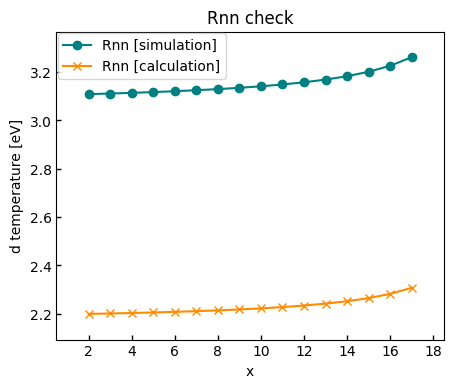

In [ ]:
Rnn = np.sqrt(reg["Tnlim"] / Mi) / neutral_lmax
nu = 0

# calc = Rnn
# sim = reg["Kd_mfp_pseudo_coll"]

calc = np.sqrt(reg["Tnlim"] / Mi)
sim = reg["debug"]

fig, ax = plt.subplots(dpi = 100)
sim.plot(ax=ax, marker = "o", label = "Rnn [simulation]")
calc.plot(ax = ax, marker = "x", label = "Rnn [calculation]")

ax.set_title("Rnn check")
ax.legend()

# Check unlimited Dnn

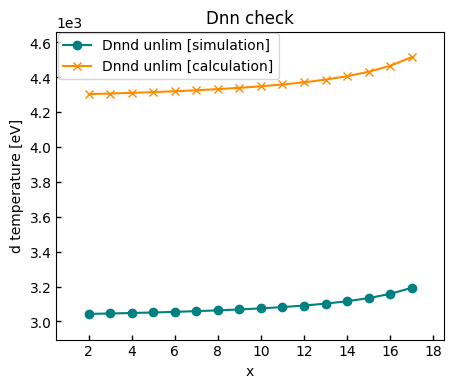

In [ ]:
Dnn_unlim = (reg["Tnlim"] / Mi) / (nu + Rnn)

fig, ax = plt.subplots(dpi = 100)

reg["Dnnd_unlimited"].plot(ax=ax, marker = "o", label = "Dnnd unlim [simulation]")
Dnn_unlim.plot(ax = ax, marker = "x", label = "Dnnd unlim [calculation]")

ax.set_title("Dnn check")
ax.legend()

# Check limited Dnn

In [ ]:
Mi

2

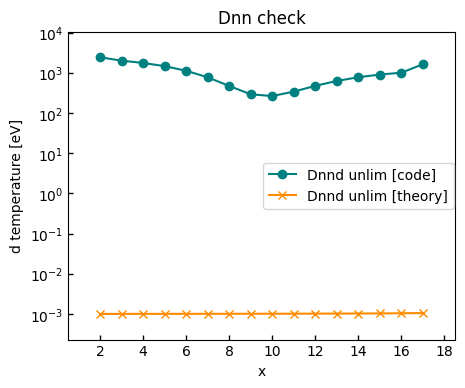

In [ ]:


Pnlim = reg["Pd"]
# grad_Pnlim, _, _ = grad_perp(reg, Pnlim)

Dmax = flux_limit * np.sqrt(reg["Td"] / Mi) / (np.abs(reg["grad_perp_logPnlim_x_calc"]) + neutral_lmax) 

fig, ax = plt.subplots(dpi = 100)

reg["Dnnd_max"].plot(ax=ax, marker = "o", label = "Dnnd unlim [code]")
Dmax.plot(ax = ax, marker = "x", label = "Dnnd unlim [theory]")

ax.set_title("Dnn check")
ax.legend()
ax.set_yscale("log")

In [ ]:
#

NameError: name 'dsx' is not defined

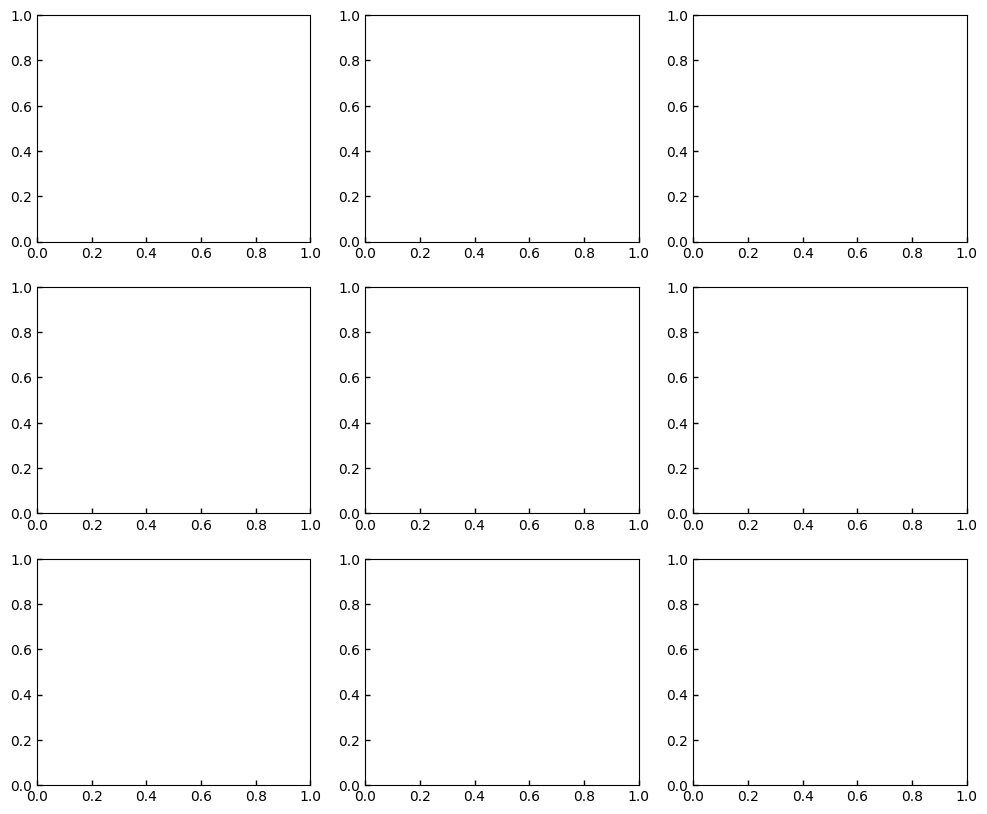

In [ ]:

fig, axes = plt.subplots(3,3, figsize=(12,10))

ax = axes[0,0]
dsx["pfh_adv_perp_xlow"].plot(ax = ax, marker="o")
ax.set_title("pfh_adv_perp_xlow")
ax.set_ylabel("[s^-1]")

ax = axes[1,0]
dsx["efh_adv_perp_xlow"].plot(ax = ax, marker="o")
ax.set_title("efh_adv_perp_xlow")
ax.set_ylabel("W")

ax = axes[2,0]
dsx["mfh_adv_perp_xlow"].plot(ax = ax, marker="o")
ax.set_title("mfh_adv_perp_xlow")
ax.set_ylabel("N")

ax = axes[0,1]
dsy["efh_cond_par_ylow"].plot(ax = ax, marker="o")
ax.set_title("efh_cond_par_ylow")
ax.set_ylabel("W")

ax = axes[1,1]
dsx["efh_cond_perp_xlow"].plot(ax = ax, marker="o")
ax.set_title("efh_cond_perp_xlow")
ax.set_ylabel("W")

ax = axes[0,2]
dsy["mfh_visc_par_ylow"].plot(ax = ax, marker="o")
ax.set_title("mfh_visc_par_ylow")
ax.set_ylabel("N")

ax = axes[1,2]
dsx["mfh_visc_perp_xlow"].plot(ax = ax, marker="o")
ax.set_title("mfh_visc_perp_xlow")
ax.set_ylabel("N")

fig.tight_layout()

In [ ]:
reg[""]

KeyError: "No variable named ''. Variables on the dataset include ['Bxy', 'Dnnh', 'Dnnh_unlimited', 'G1', 'G2', ..., 'wtime_rhs', 't', 'x', 'y', 'z']"

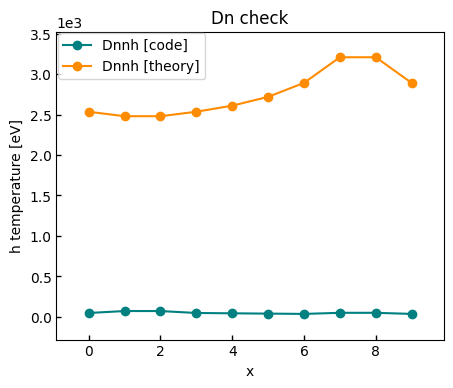

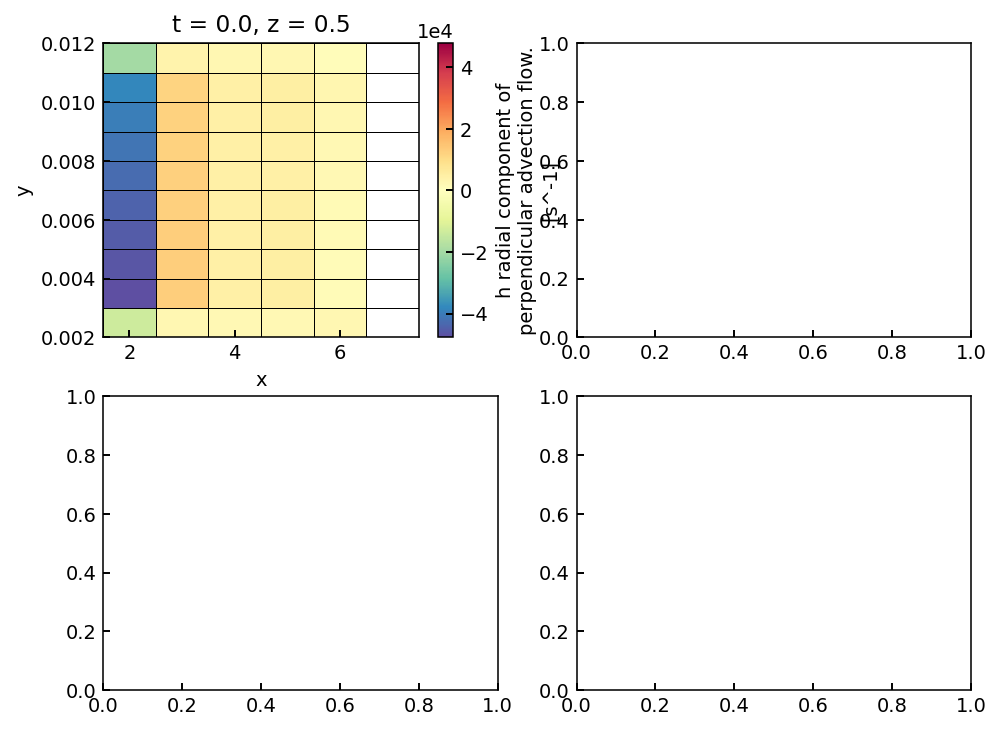

In [ ]:
dsl = ds.isel(t=-1).squeeze().isel(x= slice(2,-2), y = slice(2,-2))
fig, axes = plt.subplots(2,2, figsize=(8,6))

style = {"cmap":"Spectral_r", "linewidth":0.5, "color":"k", "x":"x", "y":"y"}

ax = axes[0,0]
xlow = dsl["pfh_adv_perp_xlow"]
xup = dsl["pfh_adv_perp_xlow"].shift(x=-1)
centre = xlow - xup
centre.plot(ax = ax, **style)

Text(0.5, 1.0, 'Temperature')

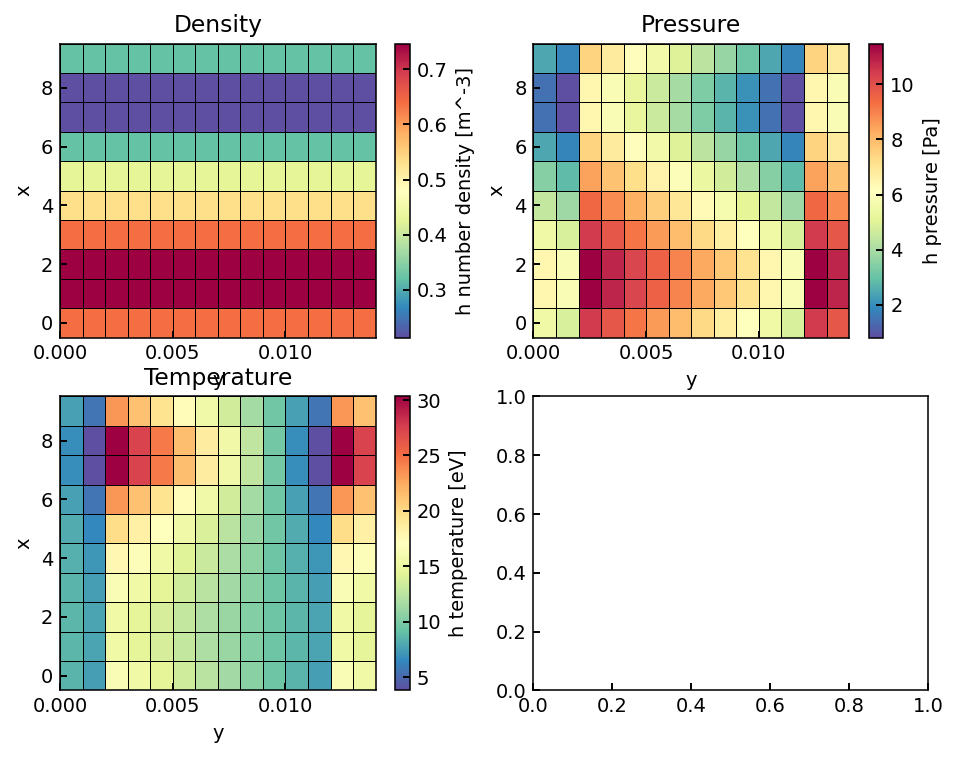

In [ ]:
dsl = ds.isel(t=-1).squeeze()#.isel(x= slice(2,-2), y = slice(2,-2))

fig, axes = plt.subplots(2,2, figsize=(8,6))
style = {"cmap":"Spectral_r", "linewidth":0.5, "color":"k"}

ax = axes[0,0]
dsl["Nh"].plot(ax = ax, **style)
ax.set_title("Density")

ax = axes[0,1]
dsl["Ph"].plot(ax = ax, **style)
ax.set_title("Pressure")

ax = axes[1,0]
dsl["Th"].plot(ax = ax, **style)
ax.set_title("Temperature")